# RAG

In [1]:
# Loading a document to be used for retrieval
from langchain_community.document_loaders import PyPDFLoader

pdf_file = "~/Desktop/langchain_concepts/hdfc_policy_doc.pdf"

In [2]:
pdf_loader = PyPDFLoader(pdf_file)
# will load each page as a document, with lazy loading
document_pages = []
async for page in pdf_loader.alazy_load():
    document_pages.append(page)

In [3]:
len(document_pages)

48

In [4]:
document_pages[0]

Document(metadata={'producer': 'Microsoft® Word LTSC', 'creator': 'Microsoft® Word LTSC', 'creationdate': '2025-03-10T17:06:03+05:30', 'author': 'harinis', 'moddate': '2025-03-10T17:06:03+05:30', 'source': '/Users/sarmehta/Desktop/langchain_concepts/hdfc_policy_doc.pdf', 'total_pages': 48, 'page': 0, 'page_label': '1'}, page_content='Page 1 of 48 \n \n \nPart A \n(Welcome Letter) \n<<Date>> \n<<Policyholder’s Name>>  \n<<Policyholder’s Address>> \n<<Policyholder’s Contact Number>> \n \nSub: Your Policy no. <<>>-HDFC Life Sampoorn Nivesh Plus \n \nDear <<Policyholder’s Name>>,  \n \nWe are glad to inform you that your proposal has been accepted and the HDFC Life Sampoorn  Nivesh Plus \nPolicy (“Policy”) being this Policy, has been issued. We have made every effort to design your Policy in a \nsimple format. We have highlighted items of importance so that you may recognize them easily. \n \nPolicy document: \nAs evidence of the insurance contract between HDFC Life Insurance Company Limit

# Chat Model/ LLM Model
Here if we have the resources, we can use a local LLM chat model
or otherwise use API for LLM

In [5]:
# chat model for making the retrieval process conversational also
from langchain_huggingface import ChatHuggingFace, HuggingFacePipeline

In [6]:
# this can be used in local if we have memory, otherwise 
#through API
"""
llm_model = HuggingFacePipeline.from_model_id(
    model_id="HuggingFaceH4/zephyr-7b-beta",
    task="text-generation",
    pipeline_kwargs=dict(
        max_new_tokens=512,
        do_sample=False,
        repetition_penalty=1.03,
    ),
)
"""

'\nllm_model = HuggingFacePipeline.from_model_id(\n    model_id="HuggingFaceH4/zephyr-7b-beta",\n    task="text-generation",\n    pipeline_kwargs=dict(\n        max_new_tokens=512,\n        do_sample=False,\n        repetition_penalty=1.03,\n    ),\n)\n'

In [7]:
#chat_model = ChatHuggingFace(llm=llm_model)

In [31]:
# in case if not loading model on RAM, can use LLM API as well
import os
from api_keys import GROQ_API_KEY
from langchain.chat_models import init_chat_model

os.environ["GROQ_API_KEY"] = GROQ_API_KEY
llm_model = init_chat_model("llama3-8b-8192", model_provider="groq")

In [33]:
llm_model.invoke("hello there")

AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 12, 'total_tokens': 38, 'completion_time': 0.021666667, 'prompt_time': 0.002390955, 'queue_time': 0.336810913, 'total_time': 0.024057622}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_a97cfe35ae', 'finish_reason': 'stop', 'logprobs': None}, id='run-b06c3ce1-623e-4a13-9d9e-658763b88c0c-0', usage_metadata={'input_tokens': 12, 'output_tokens': 26, 'total_tokens': 38})

# Text Splitter
creating text splitter for our document which will break,
for document either we can go with Recursive Splitter or also Semantic splitter
if the document has content which are more of semantic reference


In [9]:
CHUNK_SIZE = 300
OVERLAP = 30
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size = CHUNK_SIZE,
                                               chunk_overlap = OVERLAP)

# Embedding Model

In [10]:
# embedding model for indexing
EMBED_DIMS = 768
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
embed_model = HuggingFaceEmbeddings(model_name = "thenlper/gte-base")

# Vector index

In [11]:
# faiss index to be used as vector store 
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain.storage import InMemoryStore

faiss_index = faiss.IndexFlatL2(EMBED_DIMS)
vector_store = FAISS(embedding_function = embed_model,
                    index = faiss_index,
                    docstore = InMemoryDocstore(),
                    index_to_docstore_id = {})

Here for providing the context to the LLM for retrieval, we have two options,

1. Chunk Context -- In this, if we just store the text spliited (chunked) documents in vector store, the vector store retriever would just retrieve the chunk for LLM would have this chunk as the context. It can be used if the chunk size is big enough, and we just need to generate an answer to the query to the user.

2. Document context -- How ever, if we need more context, and also need give the user the related document from which the answer is generated, we need to keep the mapping of the vector retrieved chunk to the original document. This can be done by using `ParentDocumentRetriever` in Langchain

In [12]:
# adding the chunked documents to the vector store
all_splits = text_splitter.split_documents(document_pages)

In [13]:
all_splits[10]

Document(metadata={'producer': 'Microsoft® Word LTSC', 'creator': 'Microsoft® Word LTSC', 'creationdate': '2025-03-10T17:06:03+05:30', 'author': 'harinis', 'moddate': '2025-03-10T17:06:03+05:30', 'source': '/Users/sarmehta/Desktop/langchain_concepts/hdfc_policy_doc.pdf', 'total_pages': 48, 'page': 0, 'page_label': '1'}, page_content='Details: XXXXXXX>> \n \nTo contact us in case of any grievance, please Click here,you may also refer to Part G. \n \nYours sincerely, \n \n \nAuthorised Signatory')

In [14]:
document_ids = vector_store.add_documents(documents=all_splits)

# Conversational Graph
We will make the RAG application in the LangGraph so as to follow the conversational flow

START -> retrieve_node(node1) --> generate_node(node2) --> END

In [15]:
#defining state class

from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [16]:
from langgraph.graph import StateGraph, START, END

In [123]:
graph_builder = StateGraph(State)

In [124]:
# node 1 for retriving context related to the question
def retrieval_node(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"], k=3)
    return {"context": retrieved_docs}

In [125]:
# node 2 for running the LLm with the context
# for this we will have to create a prompt first which 
# will contain the instruction, question, retrieved context

In [64]:
from langchain import hub

In [43]:
prompt = hub.pull("rlm/rag-prompt")

/Users/sarmehta/miniconda3/envs/langchain/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [44]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [65]:
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, PromptTemplate

In [102]:
prompt = ChatPromptTemplate(input_variables=['context', 'question'],
                            messages=[
                                HumanMessagePromptTemplate(
                                    prompt=PromptTemplate(input_variables=['context', 'question'],
                                                          template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:")
                                )])

In [103]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [126]:
def response_node(state: State):
    full_context = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": full_context})
    #print(messages)
    response = llm_model.invoke(messages)
    return {"answer": response.content}

In [127]:
# connecting nodes to build graph
#START
graph_builder.add_edge(START, "retrieval_node")

# RETRIEVE NODE
graph_builder.add_node("retrieval_node", retrieval_node)

#edge from retrival node to response node
graph_builder.add_edge("retrieval_node", "response_node")

# RESPONSE NODE
graph_builder.add_node("response_node", response_node)

#END
graph_builder.add_edge("response_node", END)

In [128]:
graph = graph_builder.compile()

In [129]:
print(graph.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	retrieval_node(retrieval_node)
	response_node(response_node)
	__end__([<p>__end__</p>]):::last
	__start__ --> retrieval_node;
	response_node --> __end__;
	retrieval_node --> response_node;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



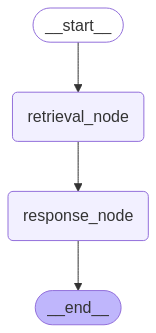

In [130]:
graph

# Streaming 
We can stream the graph in a conversational manner to get information 

To traverse through the graph, Langchain provides streaming methods
`.stream` and `.astream` are sync and async methods for streaming back outputs from a graph run. There are several different modes you can specify when calling these methods (e.g. `graph.stream(..., mode="...")):

`"values"`: This streams the full value of the state after each step of the graph.

`"updates"`: This streams the updates to the state after each step of the graph. If multiple updates are made in the same step (e.g. multiple nodes are run) then those updates are streamed separately.

`"custom"`: This streams custom data from inside your graph nodes.

`"messages"`: This streams LLM tokens and metadata for the graph node where LLM is invoked.

In [131]:
result = graph.invoke({"question": "What is Task Decomposition?"})

In [47]:
result["answer"]

'I don\'t know the answer to that question. The provided context does not mention or define "Task Decomposition".'

In [48]:
result = graph.invoke({"question": "What is HDFC insurance about?"})

In [49]:
result["answer"]

'HDFC insurance appears to be a life insurance company offering various policies, including Unit Linked Non-Participating Individual Life Insurance Savings Policies. These policies are designed to provide financial protection and savings benefits to policyholders.'

In [50]:
result

{'question': 'What is HDFC insurance about?',
 'context': [Document(id='9ead75b5-cb61-4d1d-a58f-1143c89bf33c', metadata={'producer': 'Microsoft® Word LTSC', 'creator': 'Microsoft® Word LTSC', 'creationdate': '2025-03-10T17:06:03+05:30', 'author': 'harinis', 'moddate': '2025-03-10T17:06:03+05:30', 'source': '/Users/sarmehta/Desktop/langchain_concepts/hdfc_policy_doc.pdf', 'total_pages': 48, 'page': 0, 'page_label': '1'}, page_content='IST) or email us at service@hdfclife.com. Please quote your Policy number in all correspondence. Our postal \naddress for correspondence is as specified below. You may reach out to your Certified Financial Consultant \n(Insurance Agent) who assisted you with this policy. \n \nAgent details:'),
  Document(id='ae96cbd0-f50a-4830-b1e0-fe859dcc570c', metadata={'producer': 'Microsoft® Word LTSC', 'creator': 'Microsoft® Word LTSC', 'creationdate': '2025-03-10T17:06:03+05:30', 'author': 'harinis', 'moddate': '2025-03-10T17:06:03+05:30', 'source': '/Users/sarmehta

In [132]:
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, AIMessage
def run_graph(question: str):
    for event in graph.stream(
        {"question": question},
    stream_mode = "values"):
        #print(event)
        final_result = event.get("answer")
        if final_result:
            print("Result: {}".format(final_result))
        """
        for value in event.values():
            # printing latest message in state
            # here, be careful not the return, as it will break the event cycle
            # and the process will stop after passing through first node

            #also we don't need intermediate tool outputs
            print(value)
            node_result = value["answer"][-1]
            print("Chat: {}".format(node_result.content))
            if isinstance(node_result, (HumanMessage, AIMessage)) and node_result.content:
                print("Chat: {}".format(node_result.content))
            """

In [133]:
# running the chat bot, 
while True:
    user_input = str(input("User: "))
    if user_input.lower() in ["quit", "q", "exit"]:
        break
    run_graph(user_input)

User:  what is a ship


Result: I don't know. The provided context is about scheduled airlines and insurance policy definitions, and it doesn't mention ships or vessels.


User:  what does life assured mean in the policy?


Result: In the policy, "Life Assured" refers to the person whose life the contingent events must occur for the benefits to be payable. This person may be different from the policyholder.


User:  How can i cancel this policy?


Result: You can cancel the policy by returning it to us within 30 days from the date of receipt, stating the reasons for cancellation.


User:  is there any lock in period in the policy?


Result: Yes, there is a lock-in period of five consecutive completed years from the Policy Commencement Date, during which the proceeds of the policies cannot be paid by the insurer. During this period, the policy will remain in discontinuance fund till the end of the lock-in period.


User:  who is Joe Biden?


Result: I don't know. The provided context appears to be related to a life insurance policy and does not mention Joe Biden, who is a public figure and the 46th President of the United States.


KeyboardInterrupt: Interrupted by user

User:  q
